# MobileNetV3-Large

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt

# Parameters
img_size = (224, 224)
batch_size = 32
epochs = 50
learning_rate = 0.00005  # Lowered learning rate
data_dir = '/content/drive/MyDrive/Clothing_Data_HRP'

# Adjusted Data Augmentation
transform = transforms.Compose([
    transforms.Resize(img_size),
    transforms.RandomRotation(30),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomAffine(degrees=20, translate=(0.1, 0.1), scale=(0.9, 1.1)),
    transforms.RandomResizedCrop(size=img_size, scale=(0.8, 1.0)),
    transforms.ToTensor(),
])

dataset = datasets.ImageFolder(data_dir, transform=transform)

train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Custom MobileNetV3 with BatchNorm
class CustomMobileNetV3(nn.Module):
    def __init__(self):
        super(CustomMobileNetV3, self).__init__()
        self.base_model = models.mobilenet_v3_large(pretrained=True)

        # Unfreeze last few layers for fine-tuning
        for param in self.base_model.features[-5:].parameters():
            param.requires_grad = True

        # Modify the classifier
        num_ftrs = self.base_model.classifier[0].in_features
        self.base_model.classifier = nn.Sequential(
            nn.Dropout(p=0.4),
            nn.Linear(num_ftrs, 512),
            nn.ReLU(),
            nn.BatchNorm1d(512),  # Added batch normalization
            nn.Linear(512, len(dataset.classes))
        )

    def forward(self, x):
        x = self.base_model(x)
        return x

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CustomMobileNetV3().to(device)

# Optimizer and scheduler with gradient clipping
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-3)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.0005, steps_per_epoch=len(train_loader), epochs=epochs, pct_start=0.1)
criterion = nn.CrossEntropyLoss()

# Training loop with gradient clipping
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs):
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)  # Gradient clipping
            optimizer.step()
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        # Validation step ...
        scheduler.step()

# Early stopping remains unchanged
# 7. Early Stopping (patience 7)
class EarlyStopping:
    def __init__(self, patience=7, verbose=False):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False

    def __call__(self, val_loss, model):
        score = -val_loss
        if self.best_score is None:
            self.best_score = score
        elif score < self.best_score:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.counter = 0

# 8. Training Loop with Early Stopping
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs):
    train_acc_history = []
    val_acc_history = []
    val_loss_history = []
    early_stopping = EarlyStopping(patience=7, verbose=True)

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        # Calculate training accuracy
        train_accuracy = correct / total
        train_acc_history.append(train_accuracy)

        # Validate the model
        model.eval()
        correct_val = 0
        total_val = 0
        val_loss = 0.0

        with torch.no_grad():
            for val_images, val_labels in val_loader:
                val_images, val_labels = val_images.to(device), val_labels.to(device)
                val_outputs = model(val_images)
                loss = criterion(val_outputs, val_labels)
                val_loss += loss.item()
                _, val_predicted = torch.max(val_outputs.data, 1)
                total_val += val_labels.size(0)
                correct_val += (val_predicted == val_labels).sum().item()

        # Calculate validation accuracy and loss
        val_accuracy = correct_val / total_val
        val_acc_history.append(val_accuracy)
        val_loss_history.append(val_loss)

        # Print statistics
        print(f'Epoch [{epoch+1}/{num_epochs}], Train Acc: {train_accuracy:.4f}, Val Acc: {val_accuracy:.4f}, Val Loss: {val_loss/len(val_loader):.4f}')

        # Step the scheduler
        scheduler.step()

        # Check early stopping
        early_stopping(val_loss, model)
        if early_stopping.early_stop:
            print("Early stopping triggered.")
            break

    return train_acc_history, val_acc_history, val_loss_history

# Train the model
train_acc, val_acc, val_loss = train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, epochs)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V3_Large_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V3_Large_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/mobilenet_v3_large-8738ca79.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v3_large-8738ca79.pth
100%|██████████| 21.1M/21.1M [00:00<00:00, 84.4MB/s]


Epoch [1/50], Train Acc: 0.1625, Val Acc: 0.2125, Val Loss: 2.0533
Epoch [2/50], Train Acc: 0.2406, Val Acc: 0.3125, Val Loss: 1.9355
Epoch [3/50], Train Acc: 0.3344, Val Acc: 0.3438, Val Loss: 1.8795
Epoch [4/50], Train Acc: 0.3906, Val Acc: 0.4125, Val Loss: 1.7538
Epoch [5/50], Train Acc: 0.4328, Val Acc: 0.4875, Val Loss: 1.6838
Epoch [6/50], Train Acc: 0.5047, Val Acc: 0.4875, Val Loss: 1.5861
Epoch [7/50], Train Acc: 0.5281, Val Acc: 0.5563, Val Loss: 1.4905
Epoch [8/50], Train Acc: 0.5734, Val Acc: 0.5188, Val Loss: 1.3834
Epoch [9/50], Train Acc: 0.6297, Val Acc: 0.5938, Val Loss: 1.3163
Epoch [10/50], Train Acc: 0.6672, Val Acc: 0.5437, Val Loss: 1.2541
Epoch [11/50], Train Acc: 0.6547, Val Acc: 0.6625, Val Loss: 1.1190
Epoch [12/50], Train Acc: 0.7203, Val Acc: 0.6250, Val Loss: 1.0744
Epoch [13/50], Train Acc: 0.7469, Val Acc: 0.6937, Val Loss: 0.9606
Epoch [14/50], Train Acc: 0.7609, Val Acc: 0.7125, Val Loss: 0.9061
Epoch [15/50], Train Acc: 0.7797, Val Acc: 0.7188, Val Lo

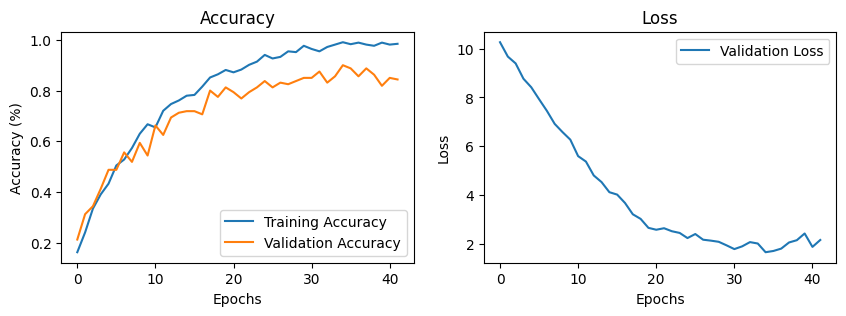

In [ ]:
# Plot training and validation accuracy and loss to check for overfitting
plt.figure(figsize=(10, 3))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(train_acc, label="Training Accuracy")
plt.plot(val_acc, label="Validation Accuracy")
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(val_loss, label="Validation Loss")
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [ ]:
from sklearn.metrics import classification_report, accuracy_score

# Function to evaluate model and generate classification report
def evaluate_model(model, val_loader):
    model.eval()  # Set the model to evaluation mode
    all_preds = []
    all_labels = []

    with torch.no_grad():  # Turn off gradients for validation
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            all_preds.extend(predicted.cpu().numpy())  # Collect predictions
            all_labels.extend(labels.cpu().numpy())    # Collect true labels

    # Calculate overall accuracy
    overall_accuracy = accuracy_score(all_labels, all_preds)
    print(f'Overall Accuracy: {overall_accuracy:.4f}')

    # Generate classification report
    report = classification_report(all_labels, all_preds, target_names=dataset.classes)
    print(f'Classification Report:\n{report}')

# Evaluate the model after training
evaluate_model(model, val_loader)

Overall Accuracy: 0.8562
Classification Report:
                       precision    recall  f1-score   support

       female_bodycon       1.00      0.89      0.94        19
 female_pant_suit_top       1.00      0.93      0.96        27
  female_pants_bottom       0.64      0.86      0.73        21
  informal cloths men       0.92      0.65      0.76        17
informal cloths women       0.72      0.93      0.81        14
           male_pants       0.83      0.62      0.71        24
            shirt men       0.91      1.00      0.95        20
            suits men       0.90      1.00      0.95        18

             accuracy                           0.86       160
            macro avg       0.87      0.86      0.85       160
         weighted avg       0.87      0.86      0.86       160



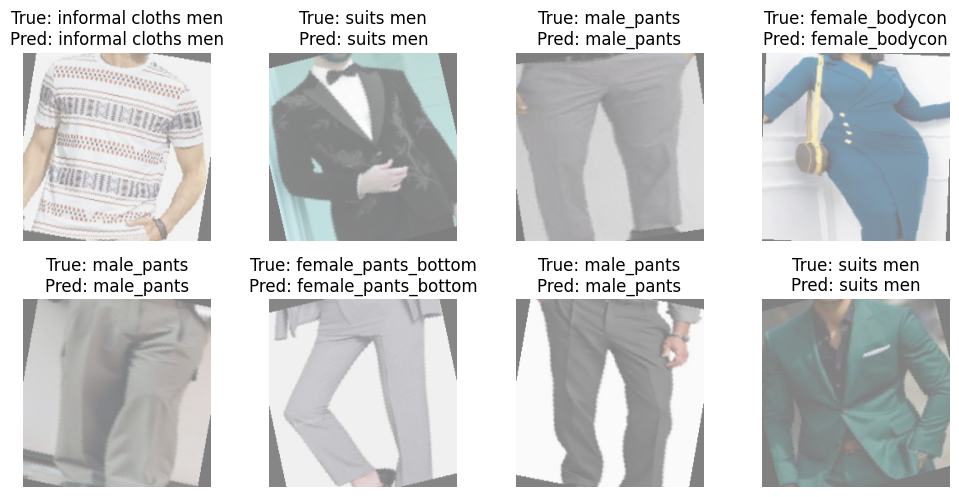

In [ ]:
# Helper function to display images along with their actual and predicted labels
def display_images(images, labels, preds, class_names):
    plt.figure(figsize=(10, 10))
    for i in range(len(images)):
        plt.subplot(4, 4, i + 1)
        img = images[i].permute(1, 2, 0).cpu().numpy()  # Convert tensor to numpy
        img = img * 0.5 + 0.5  # Unnormalize
        plt.imshow(img)
        plt.title(f"True: {class_names[labels[i]]}\nPred: {class_names[preds[i]]}", fontsize=12)  # Set fontsize to 12
        plt.axis('off')
    plt.tight_layout()  # Prevent overlap
    plt.show()

# Function to make predictions and display images
def show_predictions(model, val_loader, num_images=16):
    model.eval()
    images_displayed = 0
    images, labels, preds = [], [], []

    with torch.no_grad():
        for inputs, labels_batch in val_loader:
            inputs, labels_batch = inputs.to(device), labels_batch.to(device)
            outputs = model(inputs)
            _, preds_batch = torch.max(outputs, 1)

            # Collect images, labels, and predictions
            images.extend(inputs.cpu())
            labels.extend(labels_batch.cpu())
            preds.extend(preds_batch.cpu())

            images_displayed += len(inputs)
            if images_displayed >= num_images:
                break

    # Display a few images with predictions
    display_images(images[:num_images], labels[:num_images], preds[:num_images], dataset.classes)

# Call this function after training to display the images
show_predictions(model, val_loader, num_images=8)

# DenseNet121

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report, accuracy_score

# Parameters
img_size = (224, 224)
batch_size = 32
epochs = 50
learning_rate = 0.0001  # Increased learning rate
data_dir = '/content/drive/MyDrive/Clothing_Data_HRP'

# Data Augmentation - Reduced Aggression
transform = transforms.Compose([
    transforms.Resize(img_size),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),  # Reduced rotation angle
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.05),  # Less aggressive
    transforms.RandomResizedCrop(size=img_size, scale=(0.9, 1.0)),  # Less aggressive crop
    transforms.ToTensor(),
])

dataset = datasets.ImageFolder(data_dir, transform=transform)

train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Custom DenseNet121 Model with Unfrozen Layers and Reduced Dropout
class CustomDenseNet121(nn.Module):
    def __init__(self):
        super(CustomDenseNet121, self).__init__()
        self.base_model = models.densenet121(pretrained=True)

        # Unfreeze last 6 layers for fine-tuning
        for param in self.base_model.features[-6:].parameters():
            param.requires_grad = True

        # Modify the classifier (fully connected) layer
        num_ftrs = self.base_model.classifier.in_features
        self.base_model.classifier = nn.Sequential(
            nn.Dropout(p=0.3),  # Reduced dropout
            nn.Linear(num_ftrs, len(dataset.classes))
        )

    def forward(self, x):
        x = self.base_model(x)
        return x

# Initialize model, optimizer, loss function, and scheduler
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CustomDenseNet121().to(device)

# Weighted CrossEntropy Loss to Handle Class Imbalance
class_counts = [25, 17, 14, 15, 25, 27, 15, 22]  # Example class counts for each class
class_weights = torch.FloatTensor([1.0 / c for c in class_counts]).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights)

optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-3)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.001, steps_per_epoch=len(train_loader), epochs=epochs, pct_start=0.1)

# Early Stopping with Increased Patience
class EarlyStopping:
    def __init__(self, patience=10, verbose=False):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.best_model_wts = None

    def __call__(self, val_loss, model):
        score = -val_loss
        if self.best_score is None:
            self.best_score = score
            self.best_model_wts = model.state_dict()
        elif score < self.best_score:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.best_model_wts = model.state_dict()
            self.counter = 0

# Training loop with loss plots and accuracy tracking
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs):
    early_stopping = EarlyStopping(patience=10, verbose=True)

    train_acc_history = []
    val_acc_history = []
    val_loss_history = []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_accuracy = correct / total
        train_acc_history.append(train_accuracy)

        # Validation step
        model.eval()
        val_loss = 0.0
        correct_val = 0
        total_val = 0

        with torch.no_grad():
            for val_images, val_labels in val_loader:
                val_images, val_labels = val_images.to(device), val_labels.to(device)
                val_outputs = model(val_images)
                loss = criterion(val_outputs, val_labels)
                val_loss += loss.item()
                _, val_predicted = torch.max(val_outputs.data, 1)
                total_val += val_labels.size(0)
                correct_val += (val_predicted == val_labels).sum().item()

        val_accuracy = correct_val / total_val
        val_acc_history.append(val_accuracy)
        val_loss = val_loss / len(val_loader)
        val_loss_history.append(val_loss)

        print(f'Epoch [{epoch+1}/{num_epochs}], Train Acc: {train_accuracy:.4f}, Val Acc: {val_accuracy:.4f}, Val Loss: {val_loss:.4f}')

        scheduler.step()
        early_stopping(val_loss, model)

        if early_stopping.early_stop:
            print("Early stopping at epoch:", epoch + 1)
            break

    model.load_state_dict(early_stopping.best_model_wts)

    return model, train_acc_history, val_acc_history, val_loss_history

# Train the model
trained_model, train_acc_history, val_acc_history, val_loss_history = train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, epochs)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch [1/50], Train Acc: 0.2016, Val Acc: 0.2687, Val Loss: 1.8352
Epoch [2/50], Train Acc: 0.3984, Val Acc: 0.4625, Val Loss: 1.5145
Epoch [3/50], Train Acc: 0.5938, Val Acc: 0.6438, Val Loss: 1.2199
Epoch [4/50], Train Acc: 0.7219, Val Acc: 0.7500, Val Loss: 0.9436
Epoch [5/50], Train Acc: 0.7859, Val Acc: 0.8187, Val Loss: 0.7506
Epoch [6/50], Train Acc: 0.8594, Val Acc: 0.8375, Val Loss: 0.5618
Epoch [7/50], Train Acc: 0.9047, Val Acc: 0.8812, Val Loss: 0.4557
Epoch [8/50], Train Acc: 0.9469, Val Acc: 0.9187, Val Loss: 0.3739
Epoch [9/50], Train Acc: 0.9672, Val Acc: 0.8875, Val Loss: 0.3268
Epoch [10/50], Train Acc: 0.9609, Val Acc: 0.9313, Val Loss: 0.2772
Epoch [11/50], Train Acc: 0.9844, Val Acc: 0.9062, Val Loss: 0.2731
Epoch [12/50], Train Acc: 0.9922, Val Acc: 0.9187, Val Loss: 0.2619
Epoch [13/50], Train Acc: 0.9906, Val Acc: 0.9187, Val Loss: 0.2856
Epoch [14/50], Train Acc: 1.0000, Val Acc: 0.8938, Val Loss: 0.3180
Epoch [15/50], Train Acc: 0.9984, Val Acc: 0.9000, Val Lo

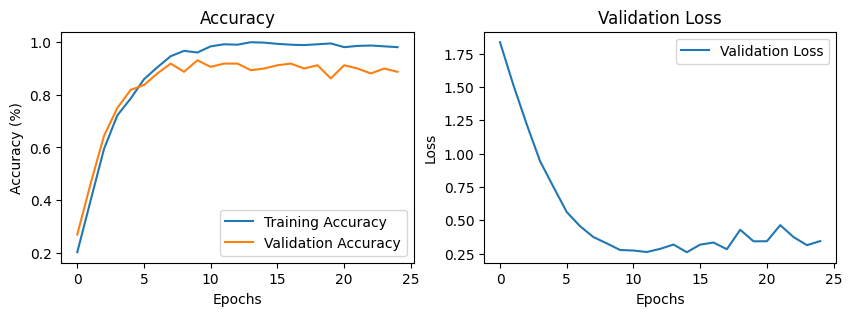

In [ ]:
# Plot training and validation accuracy and loss
plt.figure(figsize=(10, 3))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(train_acc_history, label="Training Accuracy")
plt.plot(val_acc_history, label="Validation Accuracy")
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(val_loss_history, label="Validation Loss")
plt.title('Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [ ]:
# Function to evaluate the model, calculate accuracy, and classification report
def evaluate_model(model, val_loader):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for val_images, val_labels in val_loader:
            val_images, val_labels = val_images.to(device), val_labels.to(device)
            val_outputs = model(val_images)
            _, val_predicted = torch.max(val_outputs, 1)

            all_preds.extend(val_predicted.cpu().numpy())
            all_labels.extend(val_labels.cpu().numpy())

    # Calculate overall accuracy
    overall_accuracy = accuracy_score(all_labels, all_preds)
    print(f'Overall Accuracy: {overall_accuracy * 100:.2f}%')

    # Generate classification report
    class_report = classification_report(all_labels, all_preds, target_names=dataset.classes)
    print("\nClassification Report:\n", class_report)

    return overall_accuracy, class_report

# Evaluate the model and print classification report
overall_accuracy, class_report = evaluate_model(trained_model, val_loader)

Overall Accuracy: 84.38%

Classification Report:
                        precision    recall  f1-score   support

       female_bodycon       1.00      0.79      0.88        19
 female_pant_suit_top       0.93      0.96      0.95        27
  female_pants_bottom       0.62      0.86      0.72        21
  informal cloths men       0.92      0.65      0.76        17
informal cloths women       0.76      0.93      0.84        14
           male_pants       0.82      0.58      0.68        24
            shirt men       0.87      1.00      0.93        20
            suits men       0.95      1.00      0.97        18

             accuracy                           0.84       160
            macro avg       0.86      0.85      0.84       160
         weighted avg       0.86      0.84      0.84       160



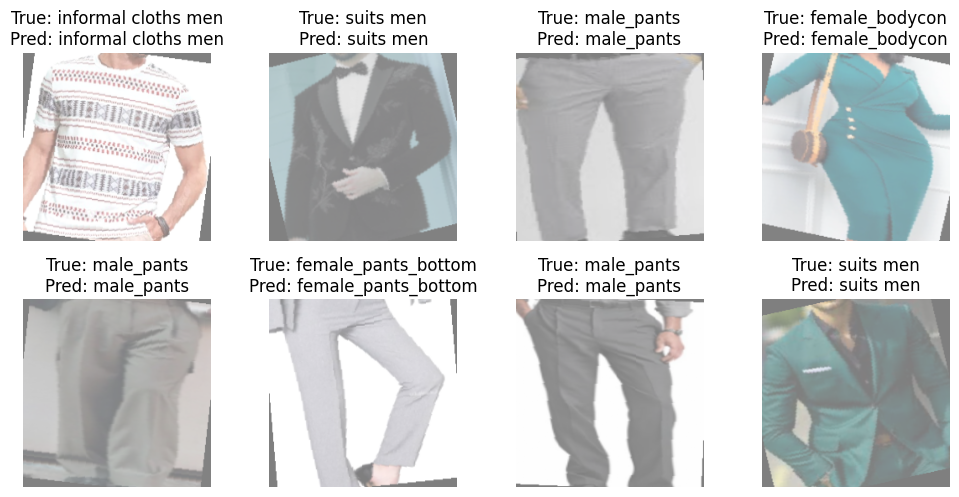

In [ ]:
# Helper function to display images along with their actual and predicted labels
def display_images(images, labels, preds, class_names):
    plt.figure(figsize=(10, 10))
    for i in range(len(images)):
        plt.subplot(4, 4, i + 1)
        img = images[i].permute(1, 2, 0).cpu().numpy()  # Convert tensor to numpy
        img = img * 0.5 + 0.5  # Unnormalize
        plt.imshow(img)
        plt.title(f"True: {class_names[labels[i]]}\nPred: {class_names[preds[i]]}", fontsize=12)  # Set fontsize to 12
        plt.axis('off')
    plt.tight_layout()  # Prevent overlap
    plt.show()

# Function to make predictions and display images
def show_predictions(model, val_loader, num_images=16):
    model.eval()
    images_displayed = 0
    images, labels, preds = [], [], []

    with torch.no_grad():
        for inputs, labels_batch in val_loader:
            inputs, labels_batch = inputs.to(device), labels_batch.to(device)
            outputs = model(inputs)
            _, preds_batch = torch.max(outputs, 1)

            # Collect images, labels, and predictions
            images.extend(inputs.cpu())
            labels.extend(labels_batch.cpu())
            preds.extend(preds_batch.cpu())

            images_displayed += len(inputs)
            if images_displayed >= num_images:
                break

    # Display a few images with predictions
    display_images(images[:num_images], labels[:num_images], preds[:num_images], dataset.classes)

# Call this function after training to display the images
show_predictions(model, val_loader, num_images=8)

# EfficientNet

In [ ]:
!pip install timm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.4/48.4 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 64.3 MB/s eta 0:00:00


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, accuracy_score
import timm

In [ ]:
model_names = timm.list_models(pretrained=True)
models= [name for name in model_names if 'efficientnetv2' in name]
models

['efficientnetv2_rw_m.agc_in1k',
 'efficientnetv2_rw_s.ra2_in1k',
 'efficientnetv2_rw_t.ra2_in1k',
 'gc_efficientnetv2_rw_t.agc_in1k',
 'tf_efficientnetv2_b0.in1k',
 'tf_efficientnetv2_b1.in1k',
 'tf_efficientnetv2_b2.in1k',
 'tf_efficientnetv2_b3.in1k',
 'tf_efficientnetv2_b3.in21k',
 'tf_efficientnetv2_b3.in21k_ft_in1k',
 'tf_efficientnetv2_l.in1k',
 'tf_efficientnetv2_l.in21k',
 'tf_efficientnetv2_l.in21k_ft_in1k',
 'tf_efficientnetv2_m.in1k',
 'tf_efficientnetv2_m.in21k',
 'tf_efficientnetv2_m.in21k_ft_in1k',
 'tf_efficientnetv2_s.in1k',
 'tf_efficientnetv2_s.in21k',
 'tf_efficientnetv2_s.in21k_ft_in1k',
 'tf_efficientnetv2_xl.in21k',
 'tf_efficientnetv2_xl.in21k_ft_in1k']

- Efficientnetv2_b0

In [ ]:
# Parameters
img_size = (224, 224)
batch_size = 32
epochs = 50
learning_rate = 0.0001
data_dir = '/content/drive/MyDrive/Clothing_Data_HRP'

# Data Augmentation
transform = transforms.Compose([
    transforms.Resize(img_size),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.05),
    transforms.RandomResizedCrop(size=img_size, scale=(0.9, 1.0)),
    transforms.ToTensor(),
])

# Load Dataset
dataset = datasets.ImageFolder(data_dir, transform=transform)

# Train and Validation Split
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# EfficientNetV2 B0 Model
class EfficientNetV2B0(nn.Module):
    def __init__(self, num_classes):
        super(EfficientNetV2B0, self).__init__()
        self.model = timm.create_model('tf_efficientnetv2_b0.in1k', pretrained=True)
        num_ftrs = self.model.get_classifier().in_features
        self.model.classifier = nn.Linear(num_ftrs, num_classes)

    def forward(self, x):
        return self.model(x)

# Initialize Model, Optimizer, Loss Function, and Scheduler
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = EfficientNetV2B0(num_classes=len(dataset.classes)).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scheduler = optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.001, steps_per_epoch=len(train_loader), epochs=epochs, pct_start=0.1)

# Early Stopping Class
class EarlyStopping:
    def __init__(self, patience=10):
        self.patience = patience
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.best_model_wts = None

    def __call__(self, val_loss, model):
        score = -val_loss
        if self.best_score is None:
            self.best_score = score
            self.best_model_wts = model.state_dict()
        elif score < self.best_score:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.best_model_wts = model.state_dict()
            self.counter = 0

# Training Function
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs):
    early_stopping = EarlyStopping(patience=10)
    train_acc_history, val_acc_history, val_loss_history = [], [], []

    for epoch in range(num_epochs):
        model.train()
        running_loss, correct, total = 0.0, 0, 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (preds == labels).sum().item()

        train_acc = correct / total
        train_acc_history.append(train_acc)

        # Validation Step
        model.eval()
        val_loss, correct_val, total_val = 0.0, 0, 0
        with torch.no_grad():
            for val_images, val_labels in val_loader:
                val_images, val_labels = val_images.to(device), val_labels.to(device)
                val_outputs = model(val_images)
                loss = criterion(val_outputs, val_labels)
                val_loss += loss.item()
                _, val_preds = torch.max(val_outputs, 1)
                total_val += val_labels.size(0)
                correct_val += (val_preds == val_labels).sum().item()

        val_acc = correct_val / total_val
        val_loss /= len(val_loader)
        val_acc_history.append(val_acc)
        val_loss_history.append(val_loss)

        print(f'Epoch {epoch+1}/{num_epochs}, Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}, Val Loss: {val_loss:.4f}')
        scheduler.step()

        early_stopping(val_loss, model)
        if early_stopping.early_stop:
            print(f"Early stopping at epoch {epoch+1}")
            break

    model.load_state_dict(early_stopping.best_model_wts)
    return model, train_acc_history, val_acc_history, val_loss_history

# Train the model
trained_model, train_acc_history, val_acc_history, val_loss_history = train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, epochs)

model.safetensors:   0%|          | 0.00/28.8M [00:00<?, ?B/s]

Epoch 1/50, Train Acc: 0.1734, Val Acc: 0.1938, Val Loss: 2.0299
Epoch 2/50, Train Acc: 0.3953, Val Acc: 0.4188, Val Loss: 1.9546
Epoch 3/50, Train Acc: 0.5328, Val Acc: 0.5938, Val Loss: 1.8621
Epoch 4/50, Train Acc: 0.6906, Val Acc: 0.6625, Val Loss: 1.7499
Epoch 5/50, Train Acc: 0.7656, Val Acc: 0.7000, Val Loss: 1.6063
Epoch 6/50, Train Acc: 0.8203, Val Acc: 0.7688, Val Loss: 1.4265
Epoch 7/50, Train Acc: 0.8422, Val Acc: 0.7875, Val Loss: 1.2091
Epoch 8/50, Train Acc: 0.8375, Val Acc: 0.8375, Val Loss: 1.0030
Epoch 9/50, Train Acc: 0.8781, Val Acc: 0.8375, Val Loss: 0.7978
Epoch 10/50, Train Acc: 0.9016, Val Acc: 0.8187, Val Loss: 0.6420
Epoch 11/50, Train Acc: 0.9266, Val Acc: 0.8500, Val Loss: 0.5083
Epoch 12/50, Train Acc: 0.9422, Val Acc: 0.8750, Val Loss: 0.4197
Epoch 13/50, Train Acc: 0.9437, Val Acc: 0.9000, Val Loss: 0.3268
Epoch 14/50, Train Acc: 0.9734, Val Acc: 0.9125, Val Loss: 0.2985
Epoch 15/50, Train Acc: 0.9719, Val Acc: 0.9000, Val Loss: 0.3055
Epoch 16/50, Train 

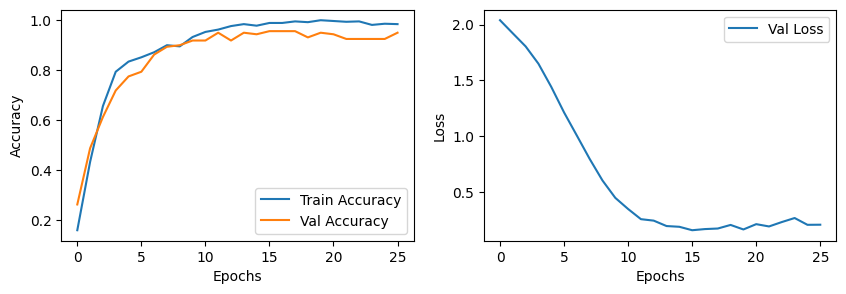

In [ ]:
# Plot accuracy and loss
plt.figure(figsize=(10, 3))
plt.subplot(1, 2, 1)
plt.plot(train_acc_history, label='Train Accuracy')
plt.plot(val_acc_history, label='Val Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(val_loss_history, label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
# Classification Report and Accuracy
def evaluate_model(model, val_loader):
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for val_images, val_labels in val_loader:
            val_images, val_labels = val_images.to(device), val_labels.to(device)
            val_outputs = model(val_images)
            _, val_preds = torch.max(val_outputs, 1)
            all_preds.extend(val_preds.cpu().numpy())
            all_labels.extend(val_labels.cpu().numpy())
    accuracy = accuracy_score(all_labels, all_preds)
    print(f"Overall Accuracy: {accuracy * 100:.2f}%")
    report = classification_report(all_labels, all_preds, target_names=dataset.classes)
    print(report)

# Evaluate model
evaluate_model(trained_model, val_loader)

Overall Accuracy: 90.62%
                       precision    recall  f1-score   support

       female_bodycon       1.00      1.00      1.00        20
 female_pant_suit_top       1.00      0.79      0.88        19
  female_pants_bottom       0.82      1.00      0.90        23
  informal cloths men       0.90      0.83      0.86        23
informal cloths women       0.83      1.00      0.91        15
           male_pants       1.00      0.81      0.89        26
            shirt men       0.89      0.94      0.91        17
            suits men       0.84      0.94      0.89        17

             accuracy                           0.91       160
            macro avg       0.91      0.91      0.91       160
         weighted avg       0.92      0.91      0.91       160



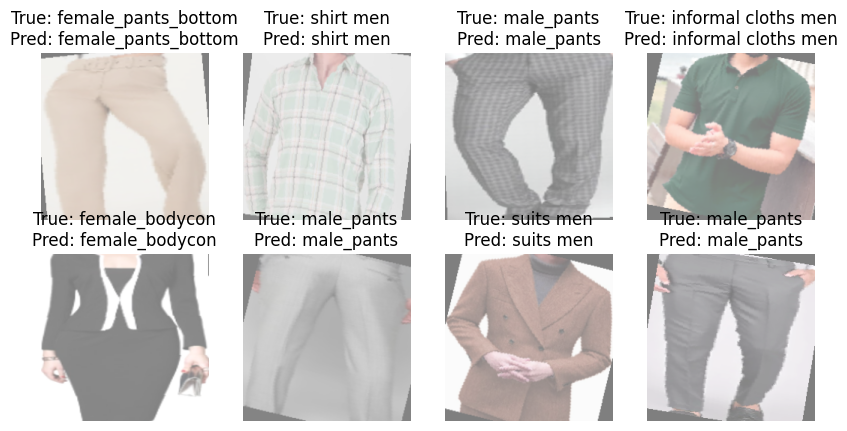

In [ ]:
# Display images with predictions
def display_images(images, labels, preds, class_names):
    plt.figure(figsize=(10, 10))
    for i in range(len(images)):
        plt.subplot(4, 4, i+1)
        img = images[i].permute(1, 2, 0).cpu().numpy() * 0.5 + 0.5  # Unnormalize
        plt.imshow(img)
        plt.title(f"True: {class_names[labels[i]]}\nPred: {class_names[preds[i]]}", fontsize=12)
        plt.axis('off')
    plt.show()

def show_predictions(model, val_loader, num_images=8):
    model.eval()
    images, labels, preds = [], [], []
    with torch.no_grad():
        for inputs, labels_batch in val_loader:
            inputs, labels_batch = inputs.to(device), labels_batch.to(device)
            outputs = model(inputs)
            _, preds_batch = torch.max(outputs, 1)
            images.extend(inputs.cpu())
            labels.extend(labels_batch.cpu())
            preds.extend(preds_batch.cpu())
            if len(images) >= num_images:
                break
    display_images(images[:num_images], labels[:num_images], preds[:num_images], dataset.classes)

# Show predictions
show_predictions(trained_model, val_loader)


- EfficientnetV3-b2

In [ ]:
# Parameters
img_size = (224, 224)
batch_size = 32
epochs = 50
learning_rate = 0.0001
data_dir = '/content/drive/MyDrive/Clothing_Data_HRP'

# Data Augmentation
transform = transforms.Compose([
    transforms.Resize(img_size),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.05),
    transforms.RandomResizedCrop(size=img_size, scale=(0.9, 1.0)),
    transforms.ToTensor(),
])

# Load Dataset
dataset = datasets.ImageFolder(data_dir, transform=transform)

# Train and Validation Split
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# EfficientNetV2 B0 Model
class EfficientNetV2B0(nn.Module):
    def __init__(self, num_classes):
        super(EfficientNetV2B0, self).__init__()
        self.model = timm.create_model('tf_efficientnetv2_b2.in1k', pretrained=True)
        num_ftrs = self.model.get_classifier().in_features
        self.model.classifier = nn.Linear(num_ftrs, num_classes)

    def forward(self, x):
        return self.model(x)

# Initialize Model, Optimizer, Loss Function, and Scheduler
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = EfficientNetV2B0(num_classes=len(dataset.classes)).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scheduler = optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.001, steps_per_epoch=len(train_loader), epochs=epochs, pct_start=0.1)

# Early Stopping Class
class EarlyStopping:
    def __init__(self, patience=10):
        self.patience = patience
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.best_model_wts = None

    def __call__(self, val_loss, model):
        score = -val_loss
        if self.best_score is None:
            self.best_score = score
            self.best_model_wts = model.state_dict()
        elif score < self.best_score:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.best_model_wts = model.state_dict()
            self.counter = 0

# Training Function
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs):
    early_stopping = EarlyStopping(patience=10)
    train_acc_history, val_acc_history, val_loss_history = [], [], []

    for epoch in range(num_epochs):
        model.train()
        running_loss, correct, total = 0.0, 0, 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (preds == labels).sum().item()

        train_acc = correct / total
        train_acc_history.append(train_acc)

        # Validation Step
        model.eval()
        val_loss, correct_val, total_val = 0.0, 0, 0
        with torch.no_grad():
            for val_images, val_labels in val_loader:
                val_images, val_labels = val_images.to(device), val_labels.to(device)
                val_outputs = model(val_images)
                loss = criterion(val_outputs, val_labels)
                val_loss += loss.item()
                _, val_preds = torch.max(val_outputs, 1)
                total_val += val_labels.size(0)
                correct_val += (val_preds == val_labels).sum().item()

        val_acc = correct_val / total_val
        val_loss /= len(val_loader)
        val_acc_history.append(val_acc)
        val_loss_history.append(val_loss)

        print(f'Epoch {epoch+1}/{num_epochs}, Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}, Val Loss: {val_loss:.4f}')
        scheduler.step()

        early_stopping(val_loss, model)
        if early_stopping.early_stop:
            print(f"Early stopping at epoch {epoch+1}")
            break

    model.load_state_dict(early_stopping.best_model_wts)
    return model, train_acc_history, val_acc_history, val_loss_history

# Train the model
trained_model, train_acc_history, val_acc_history, val_loss_history = train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, epochs)

model.safetensors:   0%|          | 0.00/40.8M [00:00<?, ?B/s]

Epoch 1/50, Train Acc: 0.1594, Val Acc: 0.2625, Val Loss: 2.0383
Epoch 2/50, Train Acc: 0.4328, Val Acc: 0.4875, Val Loss: 1.9208
Epoch 3/50, Train Acc: 0.6562, Val Acc: 0.6125, Val Loss: 1.8043
Epoch 4/50, Train Acc: 0.7937, Val Acc: 0.7188, Val Loss: 1.6494
Epoch 5/50, Train Acc: 0.8344, Val Acc: 0.7750, Val Loss: 1.4425
Epoch 6/50, Train Acc: 0.8516, Val Acc: 0.7937, Val Loss: 1.2139
Epoch 7/50, Train Acc: 0.8719, Val Acc: 0.8625, Val Loss: 1.0069
Epoch 8/50, Train Acc: 0.9000, Val Acc: 0.8938, Val Loss: 0.7984
Epoch 9/50, Train Acc: 0.8953, Val Acc: 0.9000, Val Loss: 0.6056
Epoch 10/50, Train Acc: 0.9328, Val Acc: 0.9187, Val Loss: 0.4504
Epoch 11/50, Train Acc: 0.9531, Val Acc: 0.9187, Val Loss: 0.3508
Epoch 12/50, Train Acc: 0.9625, Val Acc: 0.9500, Val Loss: 0.2600
Epoch 13/50, Train Acc: 0.9766, Val Acc: 0.9187, Val Loss: 0.2469
Epoch 14/50, Train Acc: 0.9844, Val Acc: 0.9500, Val Loss: 0.1985
Epoch 15/50, Train Acc: 0.9781, Val Acc: 0.9437, Val Loss: 0.1919
Epoch 16/50, Train 

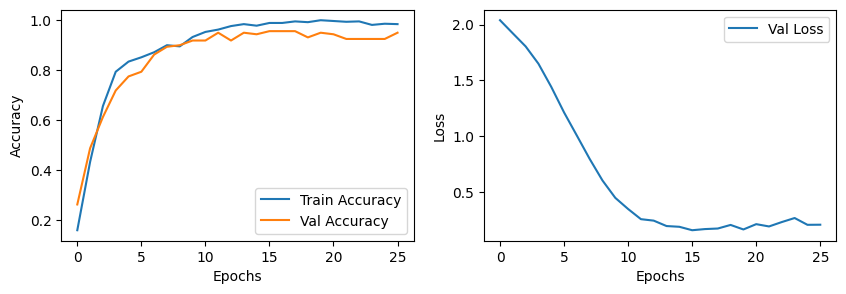

In [ ]:
# Plot accuracy and loss
plt.figure(figsize=(10, 3))
plt.subplot(1, 2, 1)
plt.plot(train_acc_history, label='Train Accuracy')
plt.plot(val_acc_history, label='Val Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(val_loss_history, label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
# Classification Report and Accuracy
def evaluate_model(model, val_loader):
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for val_images, val_labels in val_loader:
            val_images, val_labels = val_images.to(device), val_labels.to(device)
            val_outputs = model(val_images)
            _, val_preds = torch.max(val_outputs, 1)
            all_preds.extend(val_preds.cpu().numpy())
            all_labels.extend(val_labels.cpu().numpy())
    accuracy = accuracy_score(all_labels, all_preds)
    print(f"Overall Accuracy: {accuracy * 100:.2f}%")
    report = classification_report(all_labels, all_preds, target_names=dataset.classes)
    print(report)

# Evaluate model
evaluate_model(trained_model, val_loader)

Overall Accuracy: 95.00%
                       precision    recall  f1-score   support

       female_bodycon       0.93      0.93      0.93        15
 female_pant_suit_top       0.95      0.91      0.93        22
  female_pants_bottom       0.93      0.93      0.93        14
  informal cloths men       0.92      0.96      0.94        23
informal cloths women       1.00      1.00      1.00        15
           male_pants       0.95      0.95      0.95        19
            shirt men       0.96      0.96      0.96        28
            suits men       0.96      0.96      0.96        24

             accuracy                           0.95       160
            macro avg       0.95      0.95      0.95       160
         weighted avg       0.95      0.95      0.95       160

